<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/Audio_signals_Research/blob/master/denoise_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from scipy.io import wavfile
import scipy.io
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [77]:
sr,x = wavfile.read("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array1-05.wav")
plt.figure(figsize=(14, 5))
duration = len(x)/sr
time = np.arange(0,duration,1/sr)

<Figure size 1008x360 with 0 Axes>

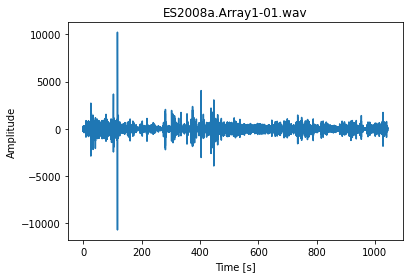

In [4]:

import matplotlib.pyplot as plt
import numpy as np
plt.plot(time,x)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('ES2008a.Array1-01.wav')
plt.show()

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend 
import tensorflow as tf
print(tf.__version__)

2.2.0


In [78]:
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/20)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [79]:
import math
signal=np.interp(x, (x.min(), x.max()), (-1, 1))
noise=get_white_noise(signal,SNR=10)

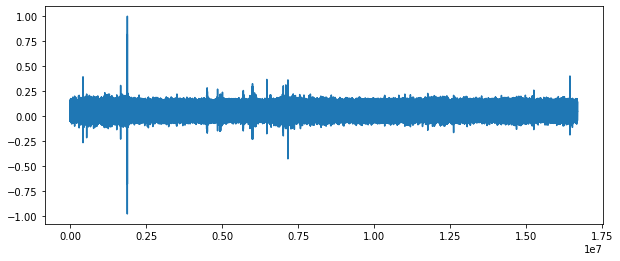

In [95]:
#from glob import glob
X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
import matplotlib.pyplot as plt
#for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array1-0*.wav"):
sr,x = wavfile.read("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array1-05.wav")
signal=np.interp(x, (x.min(), x.max()), (-1, 1))
noise=get_white_noise(signal,SNR=10)
signal_noise=signal+noise
padded = pad(signal_noise, 4096)
X.append(padded)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(signal_noise)
  #plt.plot(signal_noise)

In [96]:
X=np.vstack(X)

In [97]:
X.shape

(1, 4096)

In [93]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

In [98]:
X_check = tf.reshape(X, [64,64,1])

In [99]:
X_check.shape

TensorShape([64, 64, 1])

In [13]:
size_filter_in = 16
#normal initialization of weights
kernel_init = 'he_normal'
#To apply leaky relu after the conv layer 
activation_layer = None

In [40]:
X.shape

(1, 3000)

In [21]:
print(sr)

16000


In [22]:
input_size = (128,128,1)

In [24]:
X_in=X.reshape(-1,1)

In [26]:
X_in.shape

(3000, 1)

In [45]:
fname = "/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array1-02.wav"
import contextlib
with contextlib.closing(wave.open(fname,'r')) as f:
  frames = f.getnframes()
  rate = f.getframerate()
  width=f.getsampwidth()
  duration = frames / float(rate)

In [46]:
print(frames,rate,duration,width)

16693760 16000 1043.36 2


In [50]:
nchannels=3
framerate=rate
nframes=frames
sampwidth=width
comptype = "NONE"
compname = "not compressed"


In [51]:
#not needed 
wav_file = wave.open(fname, 'w')
wav_file.setparams(
        (nchannels,sampwidth,framerate,nframes,comptype,compname))


Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7efc2ac57208>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.6/wave.py", line 452, in _ensure_header_written
    raise Error('# channels not specified')
wave.Error: # channels not specified


In [ ]:
wav_file = wave.open(fname, 'w')
wav_file.setparams(
        (nchannels,framerate, nframes))
    for values in data:
        for v in values:
            wav_file.writeframes(struct.pack('h', int(v * amp / 2)))

In [100]:
input_size = (64,64,1)
size_filter_in = 16
#normal initialization of weights
kernel_init = 'he_normal'
#To apply leaky relu after the conv layer 
activation_layer = None
inputs = Input(input_size)
conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
conv1 = LeakyReLU()(conv1)
conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
conv1 = LeakyReLU()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
conv2 = LeakyReLU()(conv2)
conv3 = Conv2D(1, 1, activation = 'tanh')(conv2)
model = Model(inputs,conv3)


In [101]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

In [103]:
model.fit(X_check,X_check,
                epochs=10,
                batch_size=1,
                shuffle=True,
                validation_data=(X_check,X_check))

Epoch 1/10
64/64 [==============================] - 0s 5ms/step - loss: 1.0656e-05 - mae: 0.0030 - val_loss: 7.4762e-06 - val_mae: 0.0024
Epoch 2/10
64/64 [==============================] - 0s 3ms/step - loss: 6.1585e-06 - mae: 0.0021 - val_loss: 4.8789e-06 - val_mae: 0.0018
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 4.3079e-06 - mae: 0.0017 - val_loss: 3.7083e-06 - val_mae: 0.0015
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 3.3606e-06 - mae: 0.0015 - val_loss: 3.0207e-06 - val_mae: 0.0014
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 2.7872e-06 - mae: 0.0013 - val_loss: 2.3938e-06 - val_mae: 0.0012
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 2.2211e-06 - mae: 0.0012 - val_loss: 2.0221e-06 - val_mae: 0.0011
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 1.8670e-06 - mae: 0.0011 - val_loss: 1.6599e-06 - val_mae: 9.9253e-04
Epoch 8/10
64/64 [============

In [104]:
y=model.predict(X_check)

In [105]:
y.shape

(64, 64, 1, 1)

In [106]:
y1=tf.reshape(4096,1)

In [108]:
y1.shape
y2=y1.numpy()

In [109]:
from scipy.io.wavfile import write
write("example.wav", sr, y2)

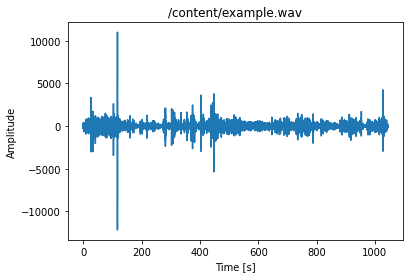

In [110]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(time,x)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('/content/example.wav')
plt.show()